In [111]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [112]:
def load_and_preprocess_data(file_path):
    # Load data
    data = pd.read_csv(file_path)

    # Split the dataset into features (spectral bands) and labels (flags)
    X = data.iloc[:, :-1].values  # Features (spectral bands)
    y = data.iloc[:, -1].values  # Labels (flags)

    # Normalize the features (spectral bands) using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape the input data for LSTM model
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

    return X_reshaped, y

Epoch 1/10
764/764 [==============================] - 32s 36ms/step - loss: 0.3019 - accuracy: 0.9007
Epoch 2/10
764/764 [==============================] - 24s 32ms/step - loss: 0.2104 - accuracy: 0.9223
Epoch 3/10
764/764 [==============================] - 32s 42ms/step - loss: 0.1918 - accuracy: 0.9294
Epoch 4/10
764/764 [==============================] - 33s 43ms/step - loss: 0.1745 - accuracy: 0.9357
Epoch 5/10
764/764 [==============================] - 34s 45ms/step - loss: 0.1636 - accuracy: 0.9391
Epoch 6/10
764/764 [==============================] - 34s 45ms/step - loss: 0.1571 - accuracy: 0.9405
Epoch 7/10
764/764 [==============================] - 31s 41ms/step - loss: 0.1541 - accuracy: 0.9416
Epoch 8/10
764/764 [==============================] - 31s 41ms/step - loss: 0.1495 - accuracy: 0.9426
Epoch 9/10
764/764 [==============================] - 31s 41ms/step - loss: 0.1485 - accuracy: 0.9430
Epoch 10/10
764/764 [==============================] - 32s 42ms/step - loss: 0.146

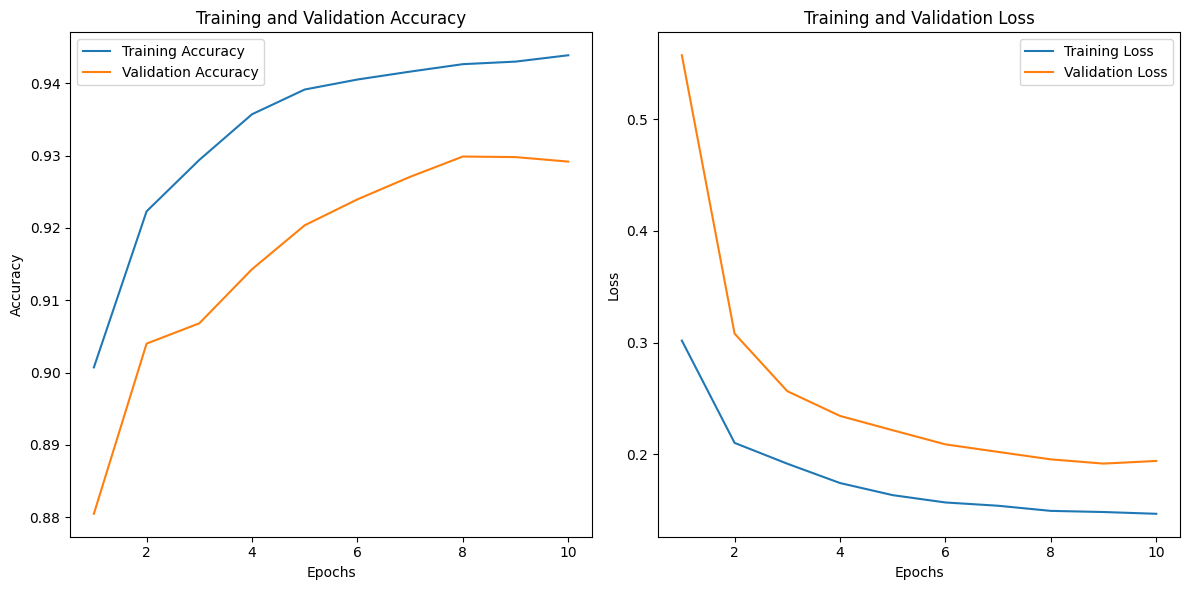

1905/1905 [==============================] - 12s 5ms/step - loss: 1.3806 - accuracy: 0.1610
Final accuracy on the test dataset: 0.16102084517478943
Final loss on the test dataset: 1.3806071281433105


(None, None)

In [113]:
# Define paths for the training, validation, and test datasets
train_folder_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/0_old/train"
validate_folder_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/0_old/validate"
test_folder_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/0_old/test"

# Batch size for processing files
batch_size = 500

# Initialize history_batches list to store training histories
history_batches = []
num_classes = 4
import matplotlib.pyplot as plt

def process_folder(folder_path, is_test=False):
    X_batches = []
    y_batches = []

    for root, dirs, files in os.walk(folder_path):
        for subfolder in dirs:
            subfolder_path = os.path.join(root, subfolder)
            if subfolder == "0":
                file_paths = [os.path.join(subfolder_path, filename) for filename in os.listdir(subfolder_path) if filename.endswith(".csv")]
                if file_paths:
                    for file_path in file_paths:
                        if os.path.basename(file_path) == "dates.csv":
                            print("Skipping file:", file_path)
                            continue

                        X, y = load_and_preprocess_data(file_path)
                        X_batches.append(X)
                        y_batches.append(y)

    if X_batches:
        X_data = np.concatenate(X_batches)
        y_data = np.concatenate(y_batches)

        # Define the LSTM model
        inputs = Input(shape=(X_data.shape[1], X_data.shape[2]))
        # First LSTM layer
        lstm_layer1 = LSTM(units=64, return_sequences=True)(inputs)
        dropout1 = Dropout(0.5)(lstm_layer1)

# Second LSTM layer
        lstm_layer2 = LSTM(units=64, return_sequences=True)(dropout1)
        dropout2 = Dropout(0.5)(lstm_layer2)

# Third LSTM layer (optional)
        lstm_layer3 = LSTM(units=64)(dropout2)
        dropout3 = Dropout(0.5)(lstm_layer3)

# Output layer
        outputs = Dense(4, activation='softmax')(dropout3)

# Define the model
        model = Model(inputs=inputs, outputs=outputs)

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # One-hot encode the target data
        y_data_encoded = to_categorical(y_data)

        # Train the model
        if not is_test:
            # Train the model on the entire dataset without validation split
            history = model.fit(X_data, y_data_encoded, epochs=10, batch_size=200, verbose=1)
            history_batches.append(history)
        else:
            # Evaluate the model on the test dataset
            test_loss, test_accuracy = model.evaluate(X_data, y_data_encoded)
            print("Final accuracy on the test dataset:", test_accuracy)
            print("Final loss on the test dataset:", test_loss)

            # Return None for train_accuracy and train_loss in test mode
            return None, None

        tf.keras.backend.clear_session()
        del model

        # Return training accuracy, validation accuracy, training loss, and validation loss if available
        train_accuracy = history.history['accuracy']
        train_loss = history.history['loss']

        return train_accuracy, train_loss

# Process the training dataset
train_accuracy, train_loss = process_folder(train_folder_path)

# Process the validation dataset (no need for validation split)
val_accuracy, val_loss = process_folder(validate_folder_path)

# Plot training and validation accuracy in a single graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
if train_accuracy:
    plt.plot(range(1, 11), train_accuracy, label='Training Accuracy')  # Update the range to match the number of epochs
if val_accuracy:
    plt.plot(range(1, 11), val_accuracy, label='Validation Accuracy')  # Update the range to match the number of epochs
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
if train_loss:
    plt.plot(range(1, 11), train_loss, label='Training Loss')  # Update the range to match the number of epochs
if val_loss:
    plt.plot(range(1, 11), val_loss, label='Validation Loss')  # Update the range to match the number of epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Process the test dataset
process_folder(test_folder_path, is_test=True)
